In [1]:
import zombie_imp
import csv
import serial
import time 
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
import pywt
import numpy as np
from scipy import stats
import statistics
from scipy.interpolate import interp1d
from sklearn.neighbors import KNeighborsClassifier

## Read the data from serial port

In [3]:
# Initialize the Serial port
ser = serial.Serial('COM3', 115200)  # Change the port and baud rate according to transmitter

# create the CSV file
# with open('sensor_data.csv', mode='w', newline='') as file:
#     writer = csv.writer(file)
#     writer.writerow(['Cell 1', 'Cell 2', 'Cell 3'])  

#     # read the data from port and store in CSV file
#     try:
#         while True:
#             data = ser.readline().decode('utf-8', errors='ignore').strip()  # read data from port
#             if data:
#                 values = data.split(' ')  # split with space
#                 if len(values) == 3:  # make sure there are three values
#                     writer.writerow([int(val) for val in values])  # store the data
#     except KeyboardInterrupt:  # stop iteration by Ctrl+C
#         pass

#for two cells
with open('sensor_data.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Cell 1', 'Cell 2'])  

    # read the data from port and store in CSV file
    try:
        while True:
            data = ser.readline().decode('utf-8', errors='ignore').strip()  # read data from port
            if data:
                values = data.split(' ')  # split with space
                if len(values) == 2:  # make sure there are three values
                    writer.writerow([int(val) for val in values])  # store the data
    except KeyboardInterrupt:  # stop iteration by Ctrl+C
        pass
    finally:
        ser.close()
        
# #for one cell
# with open('sensor_data.csv', mode='w', newline='') as file:
#     writer = csv.writer(file)
#     writer.writerow(['Sensor Value']) 

#     try:
#         while True:
#             data = ser.readline().decode('utf-8').strip()  
#             if data:
#                 writer.writerow([int(data)])  
#     except KeyboardInterrupt:  
#         pass
#     finally:
#         ser.close()

## Load the CSV files for different gestures

In [5]:
# read the csv file
df_1 = pd.read_csv('two_cells/flat_hand.csv')
df_2 = pd.read_csv('two_cells/vertical_hand.csv')

# get the data of each solar cell
solar_cell_1_flat = df_1['Cell 1']
solar_cell_2_flat = df_1['Cell 2']
solar_cell_1_vertical = df_2['Cell 1']
solar_cell_2_vertical = df_2['Cell 2']
# solar_cell_2 = df['Cell 2']
# solar_cell_3 = df['Cell 3']

# apply DWT for the current value of each solar cell
coeffs_1_flat = pywt.wavedec(solar_cell_1_flat, 'haar', level=5) #coeffs_1[0] contains the first-level approximation coefficient of solar_cell_1, coeffs_1[1] contains the first-level detail coefficient of solar_cell_1
coeffs_2_flat = pywt.wavedec(solar_cell_2_flat, 'haar', level=5)
coeffs_1_vertical = pywt.wavedec(solar_cell_1_vertical, 'haar', level=5)
coeffs_2_vertical = pywt.wavedec(solar_cell_2_vertical, 'haar', level=5)
# coeffs_2 = pywt.wavedec(solar_cell_2, 'haar', level=5)
# coeffs_3 = pywt.wavedec(solar_cell_3, 'haar', level=5)

# cA5, cD5, cD4, cD3, cD2, cD1 = coeffs_1

# print("Coefficients for solar_cell_1:", cA5)
# print("Coefficients for solar_cell_2:", coeffs_2)
# print("Coefficients for solar_cell_3:", coeffs_3)

## Use DWT to denoise

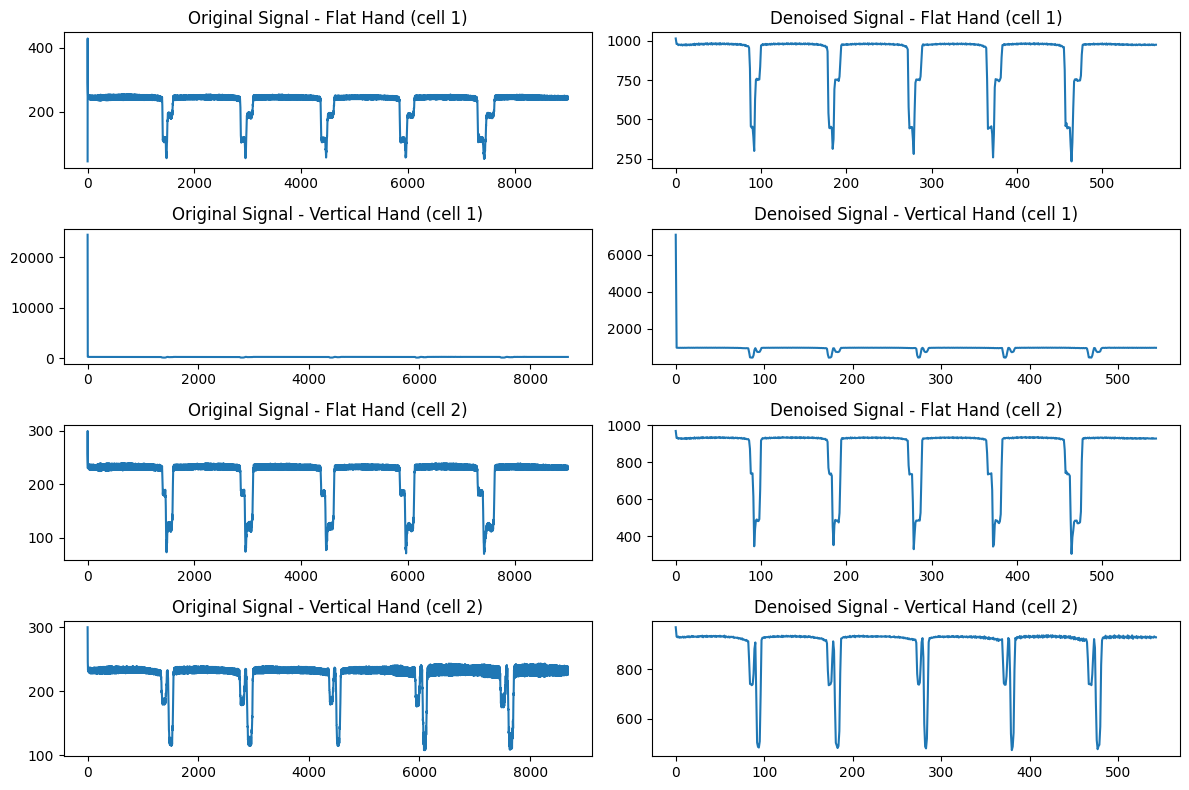

In [6]:
# should be changed based on reality
threshold = 0.4

# For cell 1
approx_coeff_1_flat = coeffs_1_flat[0]
detail_coeff_1_flat = coeffs_1_flat[1]
approx_coeff_1_vertical = coeffs_1_vertical[0]
detail_coeff_1_vertical = coeffs_1_vertical[1]

## Apply a threshold on the detail coefficient on signals of cell 1
detail_coeff_thresh_1_flat = pywt.threshold(detail_coeff_1_flat, threshold, mode='soft')
detail_coeff_thresh_1_vertical = pywt.threshold(detail_coeff_1_vertical, threshold, mode='soft')

## Reconstruct the signal for different gestures of cell 1
coeffs_denoised_1_flat = [approx_coeff_1_flat, detail_coeff_thresh_1_flat]
solar_cell_denoised_1_flat = pywt.waverec(coeffs_denoised_1_flat, 'haar')
coeffs_denoised_1_vertical = [approx_coeff_1_vertical, detail_coeff_thresh_1_vertical]
solar_cell_denoised_1_vertical = pywt.waverec(coeffs_denoised_1_vertical, 'haar')

# For cell 2
approx_coeff_2_flat = coeffs_2_flat[0]
detail_coeff_2_flat = coeffs_2_flat[1]
approx_coeff_2_vertical = coeffs_2_vertical[0]
detail_coeff_2_vertical = coeffs_2_vertical[1]

## Apply a threshold on the detail coefficient of signals of cell 2
detail_coeff_thresh_2_flat = pywt.threshold(detail_coeff_2_flat, threshold, mode='soft')
detail_coeff_thresh_2_vertical = pywt.threshold(detail_coeff_2_vertical, threshold, mode='soft')

## Reconstruct the signal for different gestures of cell 2
coeffs_denoised_2_flat = [approx_coeff_2_flat, detail_coeff_thresh_2_flat]
solar_cell_denoised_2_flat = pywt.waverec(coeffs_denoised_2_flat, 'haar')
coeffs_denoised_2_vertical = [approx_coeff_2_vertical, detail_coeff_thresh_2_vertical]
solar_cell_denoised_2_vertical = pywt.waverec(coeffs_denoised_2_vertical, 'haar')


# plot the comparison of single before and after denoising
plt.figure(figsize=(12, 8))

plt.subplot(4, 2, 1)
plt.plot(solar_cell_1_flat)
plt.title('Original Signal - Flat Hand (cell 1)')

plt.subplot(4, 2, 2)
plt.plot(solar_cell_denoised_1_flat)
plt.title('Denoised Signal - Flat Hand (cell 1)')

plt.subplot(4, 2, 3)
plt.plot(solar_cell_1_vertical)
plt.title('Original Signal - Vertical Hand (cell 1)')

plt.subplot(4, 2, 4)
plt.plot(solar_cell_denoised_1_vertical)
plt.title('Denoised Signal - Vertical Hand (cell 1)')

plt.subplot(4, 2, 5)
plt.plot(solar_cell_2_flat)
plt.title('Original Signal - Flat Hand (cell 2)')

plt.subplot(4, 2, 6)
plt.plot(solar_cell_denoised_2_flat)
plt.title('Denoised Signal - Flat Hand (cell 2)')

plt.subplot(4, 2, 7)
plt.plot(solar_cell_2_vertical)
plt.title('Original Signal - Vertical Hand (cell 2)')

plt.subplot(4, 2, 8)
plt.plot(solar_cell_denoised_2_vertical)
plt.title('Denoised Signal - Vertical Hand (cell 2)')


plt.tight_layout()
plt.show()

## Detect the start and the end of gesture

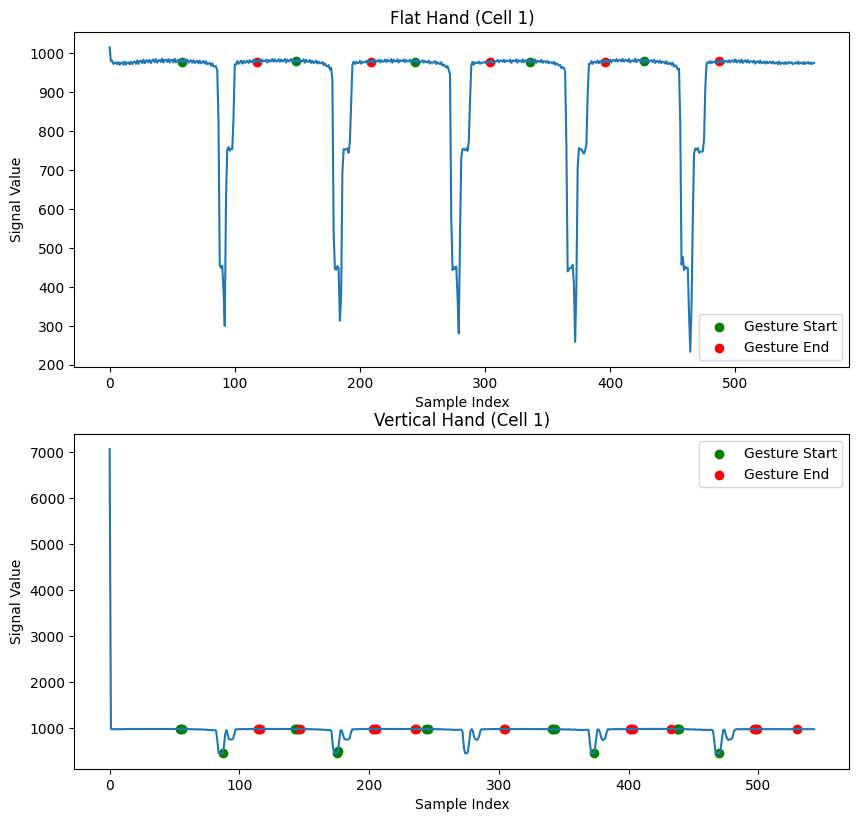

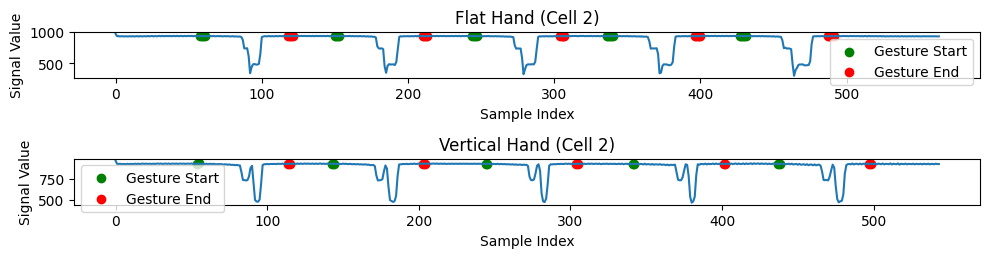

In [11]:
def detect_gesture_starts_ends(signal, window_size, std_threshold, mean_threshold):
    starts = []
    ends = []

    for i in range(len(signal) - window_size):
        window = signal[i:i+window_size]
        std_dev = np.std(window)
        mean = np.mean(window)
        last_sample = window[-1]

        if std_dev < std_threshold and abs(last_sample - mean) > mean_threshold:
            starts.append(i)
            ends.append(i + 2*window_size)

    return starts, ends

# Get the start and end points of hand gesture of cell 1
zscore_solar_cell_1_flat = stats.zscore(solar_cell_denoised_1_flat)
zscore_solar_cell_1_vertical = stats.zscore(solar_cell_denoised_1_vertical)
starts_1_flat, ends_1_flat = detect_gesture_starts_ends(zscore_solar_cell_1_flat, 30, 0.5, 0.25) #the mean and std threshold should be changed?????????
starts_1_vertical, ends_1_vertical = detect_gesture_starts_ends(zscore_solar_cell_1_vertical, 30, 0.5, 0.25)

# Get the start and end points of hand gesture of cell 2
zscore_solar_cell_2_flat = stats.zscore(solar_cell_denoised_2_flat)
zscore_solar_cell_2_vertical = stats.zscore(solar_cell_denoised_2_vertical)
starts_2_flat, ends_2_flat = detect_gesture_starts_ends(zscore_solar_cell_2_flat, 30, 0.5, 0.25) #the mean and std threshold should be changed?????????
starts_2_vertical, ends_2_vertical = detect_gesture_starts_ends(zscore_solar_cell_2_vertical, 30, 0.5, 0.25)

## Plot the flat hand gesture of cell 1 signals
plt.figure(figsize=(10, 20))
plt.subplot(4, 1, 1)  # Create a subplot with 2 rows and 1 column, select the first subplot
plt.plot(solar_cell_denoised_1_flat)
plt.title('Flat Hand (Cell 1)')

## Highlight the start and end points
plt.scatter(starts_1_flat, solar_cell_denoised_1_flat[starts_1_flat], color='green', label='Gesture Start')
plt.scatter(ends_1_flat, solar_cell_denoised_1_flat[ends_1_flat], color='red', label='Gesture End')

plt.xlabel('Sample Index')
plt.ylabel('Signal Value')
plt.legend()

## Plot the vertical hand gesture of cell 1 signals
plt.subplot(4, 1, 2)  # Select the second subplot
plt.plot(solar_cell_denoised_1_vertical)
plt.title('Vertical Hand (Cell 1)')

## Highlight the start and end points
plt.scatter(starts_1_vertical, solar_cell_denoised_1_vertical[starts_1_vertical], color='green', label='Gesture Start')
plt.scatter(ends_1_vertical, solar_cell_denoised_1_vertical[ends_1_vertical], color='red', label='Gesture End')

plt.xlabel('Sample Index')
plt.ylabel('Signal Value')
plt.legend()

## Plot the flat hand gesture of cell 2 signals
plt.figure(figsize=(10, 5))
plt.subplot(4, 1, 3)  # Create a subplot with 2 rows and 1 column, select the first subplot
plt.plot(solar_cell_denoised_2_flat)
plt.title('Flat Hand (Cell 2)')

## Highlight the start and end points
plt.scatter(starts_2_flat, solar_cell_denoised_2_flat[starts_2_flat], color='green', label='Gesture Start')
plt.scatter(ends_2_flat, solar_cell_denoised_2_flat[ends_2_flat], color='red', label='Gesture End')

plt.xlabel('Sample Index')
plt.ylabel('Signal Value')
plt.legend()

## Plot the vertical hand gesture of cell 1 signals
plt.subplot(4, 1, 4)  # Select the second subplot
plt.plot(solar_cell_denoised_2_vertical)
plt.title('Vertical Hand (Cell 2)')

## Highlight the start and end points
plt.scatter(starts_2_vertical, solar_cell_denoised_2_vertical[starts_2_vertical], color='green', label='Gesture Start')
plt.scatter(ends_2_vertical, solar_cell_denoised_2_vertical[ends_2_vertical], color='red', label='Gesture End')

plt.xlabel('Sample Index')
plt.ylabel('Signal Value')
plt.legend()

plt.tight_layout()  # Adjust subplot layout for better spacing
plt.show()

## Get the features of different gestures

In [12]:
def split_time_series(time_series, starts, ends):
    split_sequences = []

    for start, end in zip(starts, ends):
        split_sequences.append(time_series[start:end+1])
    
    return split_sequences

splited_solar_1_flat = split_time_series(solar_cell_1_flat, starts_1_flat, ends_1_flat)
feature_coeffs_1_flat = []
feature_std_1_flat = []
feature_mean_1_flat = []
feature_min_1_flat = []
feature_max_1_flat = []
feature_difference_1_flat = []

splited_solar_1_vertical = split_time_series(solar_cell_1_vertical, starts_1_vertical, ends_1_vertical)
feature_coeffs_1_vertical = []
feature_std_1_vertical = []
feature_mean_1_vertical = []
feature_min_1_vertical = []
feature_max_1_vertical = []
feature_difference_1_vertical = []

splited_solar_2_flat = split_time_series(solar_cell_2_flat, starts_2_flat, ends_2_flat)
feature_coeffs_2_flat = []
feature_std_2_flat = []
feature_mean_2_flat = []
feature_min_2_flat = []
feature_max_2_flat = []
feature_difference_2_flat = []

splited_solar_2_vertical = split_time_series(solar_cell_2_vertical, starts_2_vertical, ends_2_vertical)
feature_coeffs_2_vertical = []
feature_std_2_vertical = []
feature_mean_2_vertical = []
feature_min_2_vertical = []
feature_max_2_vertical = []
feature_difference_2_vertical = []

target_length = 512 #target window size of interpolate
for solar_slice_1 in splited_solar_1_flat:
    #apply z score transformation on each slice
    zscore_cell1 = stats.zscore(solar_slice_1)
    
    ## Apply interpolate on every window (seems not correct)
    # Original signal with 61 sampling points
    original_signal = zscore_cell1  # Replace with your actual signal data
    # Create a time array for the original signal
    original_time = np.linspace(0, 1, len(original_signal))
    # Create a function for linear interpolation
    interpolator = interp1d(original_time, original_signal, kind='linear')
    # Create a time array for the upscaled signal
    upscaled_time = np.linspace(0, 1, 512)
    # Upscale the signal
    interpolated_solar_slice_1 = interpolator(upscaled_time)

    # calculate the detail coefficients of each slice
    slice_coeffs_1 = pywt.wavedec(interpolated_solar_slice_1, 'haar', level=5)
    feature_coeffs_1_flat.append(slice_coeffs_1[1])
    std_dev = statistics.stdev(slice_coeffs_1[1])
    feature_std_1_flat.append(std_dev)
    mean_val = np.mean(slice_coeffs_1[1])
    feature_mean_1_flat.append(mean_val)
    min_val = np.min(slice_coeffs_1[1])
    feature_min_1_flat.append(min_val)
    max_val = np.max(slice_coeffs_1[1])
    feature_max_1_flat.append(max_val)
    feature_difference_1_flat.append(max_val - min_val)

for solar_slice_2 in splited_solar_1_vertical:
    #apply z score transformation on each slice
    zscore_cell2 = stats.zscore(solar_slice_2)
    
    ## Apply interpolate on every window (seems not correct)
    # Original signal with 61 sampling points
    original_signal = zscore_cell2  # Replace with your actual signal data
    # Create a time array for the original signal
    original_time = np.linspace(0, 1, len(original_signal))
    # Create a function for linear interpolation
    interpolator = interp1d(original_time, original_signal, kind='linear')
    # Create a time array for the upscaled signal
    upscaled_time = np.linspace(0, 1, 512)
    # Upscale the signal
    interpolated_solar_slice_2 = interpolator(upscaled_time)

    # calculate the detail coefficients of each slice
    slice_coeffs_2 = pywt.wavedec(interpolated_solar_slice_2, 'haar', level=5)
    feature_coeffs_1_vertical.append(slice_coeffs_2[1])
    std_dev = statistics.stdev(slice_coeffs_2[1])
    feature_std_1_vertical.append(std_dev)
    mean_val = np.mean(slice_coeffs_2[1])
    feature_mean_1_vertical.append(mean_val)
    min_val = np.min(slice_coeffs_2[1])
    feature_min_1_vertical.append(min_val)
    max_val = np.max(slice_coeffs_2[1])
    feature_max_1_vertical.append(max_val)
    feature_difference_1_vertical.append(max_val - min_val)

for solar_slice_1 in splited_solar_2_flat:
    #apply z score transformation on each slice
    zscore_cell1 = stats.zscore(solar_slice_1)
    
    ## Apply interpolate on every window (seems not correct)
    # Original signal with 61 sampling points
    original_signal = zscore_cell1  # Replace with your actual signal data
    # Create a time array for the original signal
    original_time = np.linspace(0, 1, len(original_signal))
    # Create a function for linear interpolation
    interpolator = interp1d(original_time, original_signal, kind='linear')
    # Create a time array for the upscaled signal
    upscaled_time = np.linspace(0, 1, 512)
    # Upscale the signal
    interpolated_solar_slice_1 = interpolator(upscaled_time)

    # calculate the detail coefficients of each slice
    slice_coeffs_1 = pywt.wavedec(interpolated_solar_slice_1, 'haar', level=5)
    feature_coeffs_2_flat.append(slice_coeffs_1[1])
    std_dev = statistics.stdev(slice_coeffs_1[1])
    feature_std_2_flat.append(std_dev)
    mean_val = np.mean(slice_coeffs_1[1])
    feature_mean_2_flat.append(mean_val)
    min_val = np.min(slice_coeffs_1[1])
    feature_min_2_flat.append(min_val)
    max_val = np.max(slice_coeffs_1[1])
    feature_max_2_flat.append(max_val)
    feature_difference_2_flat.append(max_val - min_val)

for solar_slice_2 in splited_solar_2_vertical:
    #apply z score transformation on each slice
    zscore_cell2 = stats.zscore(solar_slice_2)
    
    ## Apply interpolate on every window (seems not correct)
    # Original signal with 61 sampling points
    original_signal = zscore_cell2  # Replace with your actual signal data
    # Create a time array for the original signal
    original_time = np.linspace(0, 1, len(original_signal))
    # Create a function for linear interpolation
    interpolator = interp1d(original_time, original_signal, kind='linear')
    # Create a time array for the upscaled signal
    upscaled_time = np.linspace(0, 1, 512)
    # Upscale the signal
    interpolated_solar_slice_2 = interpolator(upscaled_time)

    # calculate the detail coefficients of each slice
    slice_coeffs_2 = pywt.wavedec(interpolated_solar_slice_2, 'haar', level=5)
    feature_coeffs_2_vertical.append(slice_coeffs_2[1])
    std_dev = statistics.stdev(slice_coeffs_2[1])
    feature_std_2_vertical.append(std_dev)
    mean_val = np.mean(slice_coeffs_2[1])
    feature_mean_2_vertical.append(mean_val)
    min_val = np.min(slice_coeffs_2[1])
    feature_min_2_vertical.append(min_val)
    max_val = np.max(slice_coeffs_2[1])
    feature_max_2_vertical.append(max_val)
    feature_difference_2_vertical.append(max_val - min_val)
    
print("Flat Hand cell 1")
# print(feature_coeffs_1)
print(feature_std_1_flat)
print(feature_mean_1_flat)
print(feature_min_1_flat)
print(feature_max_1_flat)
print(feature_difference_1_flat)
print("Vertical Hand cell 1")
# print(feature_coeffs_2)
print(feature_std_1_vertical)
print(feature_mean_1_vertical)
print(feature_min_1_vertical)
print(feature_max_1_vertical)
print(feature_difference_1_vertical)
print("Flat Hand cell 2")
# print(feature_coeffs_1)
print(feature_std_2_flat)
print(feature_mean_2_flat)
print(feature_min_2_flat)
print(feature_max_2_flat)
print(feature_difference_2_flat)
print("Vertical Hand cell 2")
# print(feature_coeffs_2)
print(feature_std_2_vertical)
print(feature_mean_2_vertical)
print(feature_min_2_vertical)
print(feature_max_2_vertical)
print(feature_difference_2_vertical)

Flat Hand cell 1
[3.0816877320337883, 2.9102884415927086, 3.1182649946898806, 2.915405038994338, 2.9397074249620387]
[0.061917940338365896, 0.03999748548498583, 0.06797561031337646, 0.013170844422677908, 0.06346008870438391]
[-3.331468005206699, -2.846873435961729, -3.573170982946627, -3.6358411837829276, -3.5685790797394628]
[5.246728293771189, 5.6698802023539265, 5.813357258119158, 4.582765735968344, 5.0211550540592045]
[8.578196298977888, 8.516753638315656, 9.386528241065784, 8.218606919751272, 8.589734133798668]
Vertical Hand cell 1
[2.9890058972216065, 3.219048708692889, 3.0678591487844953, 2.9319058310117616, 3.007145780983117, 2.9319671544982113, 3.238061905873125, 3.1358148125285203, 3.072713718685879, 2.9158750279652517, 2.9971028877756, 3.1304280813173073, 2.955139399582056, 3.0924088407668093, 3.029274368180402, 3.0475156388634925, 3.116914552573603, 3.0008842100111925, 3.116796064155319]
[-0.04586990010535011, -0.010690480858803475, 0.07303447919889677, -0.03260408489944938

## Train the KNN model

In [13]:
X_train_flat_1 = np.column_stack((feature_min_1_flat,feature_max_1_flat, feature_mean_1_flat))
X_train_vertical_1 = np.column_stack((feature_min_1_vertical, feature_max_1_vertical, feature_mean_1_vertical))
X_train_1 = np.concatenate((X_train_flat_1, X_train_vertical_1), axis=0)

Y_train_1 = ["flat", "flat", "flat", "flat", "flat", "vertical", "vertical", "vertical", "vertical", "vertical"]
knn_model_1 = KNeighborsClassifier(n_neighbors=3)  
knn_model_1.fit(X_train_1, Y_train_1)  # train the model

X_train_flat_2 = np.column_stack((feature_min_2_flat,feature_max_2_flat, feature_mean_2_flat))
X_train_vertical_2 = np.column_stack((feature_min_2_vertical, feature_max_2_vertical, feature_mean_2_vertical))
X_train_1 = np.concatenate((X_train_flat_2, X_train_vertical_2), axis=0)

Y_train_2 = ["flat", "flat", "flat", "flat", "flat", "vertical", "vertical", "vertical", "vertical", "vertical"]
knn_model_2 = KNeighborsClassifier(n_neighbors=3)  
knn_model_2.fit(X_train_2, Y_train_2)  # train the model

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(projection='3d')

# Feature Extraction
min_2_flat, std_2_flat, mean_2_flat = X_train_flat_2[:, 0], X_train_flat_2[:, 1], X_train_flat_2[:, 2]
min_2_vertical, std_2_vertical, mean_2_vertical = X_train_vertical_2[:, 0], X_train_vertical_2[:, 1], X_train_vertical_2[:, 2]

# Plot the figure
ax.scatter(min_2_flat, std_2_flat, mean_2_flat, c='r', label='Flat Gestures')
ax.scatter(min_2_vertical, std_2_vertical, mean_2_vertical, c='b', label='Vertical Gestures')

# Add axises labels
ax.set_xlabel('Min')
ax.set_ylabel('Max')
ax.set_zlabel('Mean')

ax.legend()

plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [24, 10]

In [ ]:
ser = serial.Serial('COM3', 115200) 

try:
    while True:
        data = ser.readline().decode('utf-8').strip()
        if data:
            predicted_gesture = knn_model.predict([data_vector])

            print(f'Predicted Gesture: {predicted_gesture}')

except KeyboardInterrupt:
    pass
finally:
   
    ser.close()